In [1]:
import numpy as np
import matplotlib as mpl
import os

from PIL import Image as im
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
from matplotlib.patches import Rectangle
from scipy import ndimage as ndi

%matplotlib inline
%pprint

Pretty printing has been turned OFF


In [2]:
'''
FUNCTIONS FOR READING-IN DATA
'''

def file_list(directory, ftype):
    allflist = sorted(os.listdir(directory))
    flistlen = len(allflist)
    flist = []
    for x in range(flistlen):
        if allflist[x].endswith(str(ftype)):
            flist.append(allflist[x])
    return flist

def txt_to_list(file):
    rows = []
    processedrows = []

    with open(file, 'r') as f:
        listofrows = f.read().split('\n')
        f.close()

    for i in range(len(listofrows)):
        rowcrawler = []
        rawrow = listofrows[i].split('\t')
        rowlength = len(rawrow)
        for j in range(rowlength):
            if rawrow[j] != '':
                rowcrawler.append(int(rawrow[j]))
        rows.append(rowcrawler)

    #rows is a list of lists, where each entry (i.e. rows[0] is a list reading pixels horizontally across camera
    #rows[5] is a list of each value of every pixel in the 6th row of the image
    #rows[x] has ditched the empty value at the end of each list. But there are 257 rows, not 256. So I need to check that
    #the last row is a real value and not junk

    for j in range(len(rows)):
        if bool(rows[j]):
            processedrows.append(rows[j])
        
    # For example, consider:
    #     1 2 3
    #     4 5 6
    #     7 8 9
    # as a 3x3 pixel camera image. processedrows[0] = [1, 2, 3], and processedrows[2] = [7, 8, 9]
    # processed processedrows[hz index][vt index] accesses that pixel, so processedrows[1][2] = 6
    
    return processedrows


In [3]:
class xcam_image:
    
    '''
    ATTRIBUTES AND INITIALIZING
    '''

    def __init__(self, angle, listoflists):
        #Instantiation variables and fundamentals
        self.angle = angle
        self.image_list = listoflists
        self.image_size = None
        self.rotation = 270
        
        #Original and rotated array, read from the list-of-lists
        self.base_image_array = np.array(self.image_list, dtype=np.uint8)
        self.proc_image_array = np.rot90(self.base_image_array, int(self.rotation / 90))
        
        #Ranges for center of mass
        self.xlim_roi = (0, 255)
        self.ylim_roi = (0, 255)
        self.com = (127, 127)
        
    '''
    SETTER METHODS
    '''
    
    def set_xlim_roi(self, tup): self.xlim_roi = tup
    def set_ylim_roi(self, tup): self.ylim_roi = tup
    def set_com(self, tup): self.com = tup
    
    def set_image_size(self, scalar): self.image_size = scalar
    def set_rotation(self, n90): 
        if (n90 in [0,90,180,270]): self.rotation = n90 
        else: return print('Error: Rotate must be set to 0, 90, 180, or 270 degrees')    
    
    '''
    GETTER METHODS
    '''
    
    #Instantiation basics
    def get_name(self): return str(self.get_angle()) + ' Degrees'
    def get_angle(self): return self.angle
    def get_image_list(self): return self.image_list
    def get_image_size(self): return self.image_size

    #ROIs for center of mass
    def get_xlim_roi(self): return self.xlim_roi
    def get_ylim_roi(self): return self.ylim_roi 
    def get_com(self): return self.com

    #Image display and np arrays
    def get_base_image_array(self): return self.base_image_array
    def get_proc_image_array(self): return self.proc_image_array

    '''
    INTERNAL METHODS
    '''
    
    #Calculate the center of mass within the region of interest
    def _gen_com_array(self):
        xroi, yroi = self.get_xlim_roi(), self.get_ylim_roi()
        proc_array = self.get_proc_image_array() 
        com_list = []
        for x in range(xroi[0], xroi[1]):
            row = []
            for y in range(yroi[0], yroi[1]):
                row.append(proc_array[y][x])
            com_list.append(row)
        com_array_mirror = np.rot90(np.array(com_list), -1)
        com_array = np.fliplr(com_array_mirror)
        return com_array
    
    #Plot the array used to calculate com, make sure it's not mirrored or rotated
    def _check_com_array(self):
        size = self.get_image_size()
        if type(size) == int: fig, ax = plt.subplots(figsize = (size, size))
        else: fig, ax = plt.subplots()
        img = self._gen_com_array()
        plt.imshow(img, cmap = 'nipy_spectral', origin = 'lower')
        plt.colorbar()
        plt.title('ROI for ' + self.get_name())
        plt.show()
        return fig, ax
    
    '''
    CALCULATIONS
    '''
    
    def calc_com(self):
        roi = self._gen_com_array()
        com = ndi.center_of_mass(roi)
        com = (com[1] + self.get_xlim_roi()[0], com[0] + self.get_ylim_roi()[0])
        self.set_com(com)
        return self.get_com()
    
    '''
    IMAGE GENERATOR METHODS
    '''
    
    def gen_image_plot(self):
        size = self.get_image_size()
        img = self.get_proc_image_array() 
        if type(size) == int: fig, ax = plt.subplots(figsize = (size, size))
        else: fig, ax = plt.subplots()
        plt.imshow(img, cmap = 'nipy_spectral', origin = 'lower')
        plt.colorbar()
        return fig, ax
    
    def gen_roi_plot(self):
        fig, ax = self.gen_image_plot()
        xroi, yroi = self.get_xlim_roi(), self.get_ylim_roi()
        ax.add_patch(Rectangle((xroi[0], yroi[0]), (xroi[1] - xroi[0]), (yroi[1] - yroi[0]), 
                               edgecolor = 'white', fill=False, lw=2))
        return fig, ax
    
    def gen_com_plot(self):
        fig, ax = self.gen_roi_plot()
        plt.scatter(self.calc_com()[0], self.calc_com()[1], 350, marker = 'x',
                    color = 'magenta', linewidths = 2.5) 
        return fig, ax

    '''
    IMAGE DISPLAY METHODS
    '''
    
    def show_image(self):
        plt.close()
        fig, ax = self.gen_image_plot()
        plt.title(self.get_name())
        plt.show()
        
    def show_roi(self):
        plt.close()
        fig, ax = self.gen_roi_plot()
        plt.title('ROI for ' + self.get_name())
        plt.show()
        
    def show_com(self):
        plt.close()
        fig, ax = self.gen_com_plot()
        plt.title('Center of Mass in ROI for ' + self.get_name())
        plt.show()

In [4]:
'''
FUNCTIONS OUTSIDE OF CLASS
'''

def overlay(img1, img2, **kwargs):
    print(img1.get_name() + ': ' + str(img1.calc_com()) + '\n')
    print(img2.get_name() + ': ' + str(img2.calc_com()) + '\n')
    print('x-coord. delta: ' + str(abs(img1.calc_com()[0] - img2.calc_com()[0])))
    xroi_1, yroi_1 = img1.get_xlim_roi(), img1.get_ylim_roi()
    xroi_2, yroi_2 = img2.get_xlim_roi(), img2.get_ylim_roi()
    img1_array = img1.get_proc_image_array() 
    img2_array = img2.get_proc_image_array() 
    flag = False
    
    for key, value in kwargs.items():
        if key == 'size': flag, size = True, value

    if flag == True: fig, ax = plt.subplots(figsize = (size,size))
    else: fig, ax = plt.subplots()
    plt.imshow(img1_array, cmap = 'nipy_spectral', origin = 'lower')
    plt.imshow(img2_array, cmap = 'nipy_spectral', origin = 'lower', alpha = 0.5)
    plt.colorbar()
    
    for key, value in kwargs.items():
        if key == 'show_com' and value == True:
            com_x = [img1.calc_com()[0], img2.calc_com()[0]]
            com_y = [img1.calc_com()[1], img2.calc_com()[1]]
            plt.scatter(com_x, com_y, 350, marker = 'x', 
                        color = 'magenta', linewidths = 2.5) 
            

    plt.title('Superimposed ' + img2.get_name() + ' over ' + img1.get_name())
    plt.show()
    
def beam_tracking(img_album, **kwargs):
    units = 'Pixels'
    conv_factor = 1.0
    
    for key, value in kwargs.items():
        if key == 'units':
            if value == 'mm': units, conv_factor = 'mm', 0.055
            if value == 'um': units, conv_factor = 'um', 55
            


In [5]:
beam_tracking(10, units = 'pixels' )

In [6]:
y_roi_list = [(2, 253), #i = 0
              (2, 253),
              (2, 253),
              (2, 253),
              (2, 253),
              
              (2, 253), #i = 5
              (2, 253),
              (2, 253),
              (2, 253),
              (2, 253),
              
              (2, 253), #i = 10
              (2, 253),
              (2, 253),
              (2, 253),
              (2, 253),
              
              (2, 253), #i = 15
              (2, 253),
              (2, 253),
              (2, 253),
              (2, 253),
              
              (2, 253), #i = 20
              (4, 253),
              (8, 253),
              (20, 253),
              (50, 253),
              
              (70, 253), #i = 25
              (80, 253),
              (80, 253),
              (80, 253),
              (64, 253),
              
              (70, 253), #i = 30
              (82, 245), 
              (100, 230), 
              (110, 225), 
              (118, 215), 
              
              (128, 206), #i = 35
              (138, 202)]

In [7]:
x_roi_list = [(160, 190), #i = 0
              (160, 190),
              (160, 190),
              (161, 191),
              (161, 191), 
              
              (161, 192), #i = 5
              (161, 192),
              (161, 192),
              (161, 192),
              (161, 193),
              
              (161, 193), #i = 10
              (161, 193),
              (161, 193),
              (161, 193),
              (161, 193),
              
              (162, 192), #i = 15
              (162, 192),
              (162, 192),
              (162, 192),
              (162, 192),
              
              (162, 192), #i = 20
              (162, 192),
              (162, 193),
              (162, 193),
              (162, 193),
              
              (162, 194), #i = 25
              (163, 194),
              (164, 194),
              (164, 194),
              (164, 194),
              
              (164, 194), #i = 30
              (164, 196),
              (164, 196),
              (164, 196),
              (164, 196),
              
              (164, 196), #i = 35
              (164, 196)]

In [8]:
d = '/Users/anthonygironda/Desktop/Rowland_Tracking/'
t = '.txt'
flist = file_list(d, t)
count = len(flist)
print(str(count) + ' files in directory')
print('\n')
print(flist)

37 files in directory


['35_deg.txt', '36_deg.txt', '37_deg.txt', '38_deg.txt', '39_deg.txt', '40_deg.txt', '41_deg.txt', '42_deg.txt', '43_deg.txt', '44_deg.txt', '45_deg.txt', '46_deg.txt', '47_deg.txt', '48_deg.txt', '49_deg.txt', '50_deg.txt', '52_deg.txt', '55_deg.txt', '58_deg.txt', '60_deg.txt', '62_deg.txt', '65_deg.txt', '68_deg.txt', '70_deg.txt', '71_deg.txt', '72_deg.txt', '73_deg.txt', '74_deg.txt', '75_deg.txt', '76_deg.txt', '77_deg.txt', '78_deg.txt', '79_deg.txt', '80_deg.txt', '81_deg.txt', '82_deg.txt', '83_deg.txt']


(183.62272613131353, 126.80270849514422)


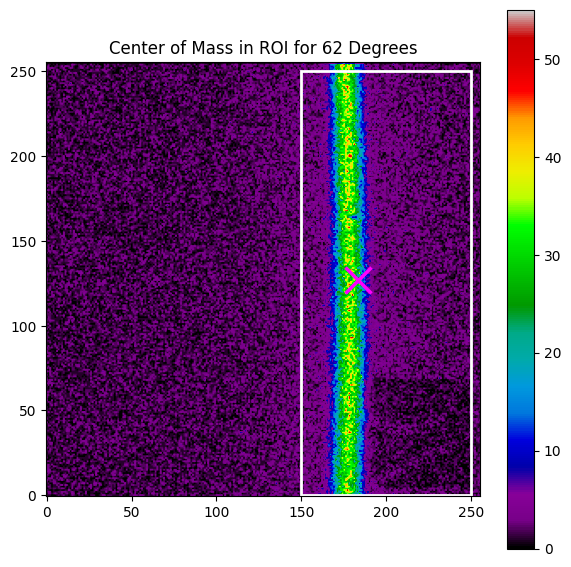

In [14]:
angle = 62
size = 7

xlow = 150
xhi = 250

ylow = 0
yhi = 250

picture = xcam_image(angle, txt_to_list(d + str(angle) + '_deg' + t))
picture.set_xlim_roi((xlow, xhi))
picture.set_ylim_roi((ylow, yhi))
picture.set_image_size(size)
print(picture.calc_com())
# picture.show_image()
# picture.show_roi()
picture.show_com()

In [22]:
album = []
com_angles = []
com_list = []
com_list_mm = []
for k in range(count):
    angle = int(flist[k][0] + flist[k][1])
    picture = xcam_image(angle, txt_to_list(d + str(angle) + '_deg' + t))
    picture.set_xlim_roi(x_roi_list[k])
    picture.set_ylim_roi(y_roi_list[k])
    album.append(picture)
    
    com_angles.append(angle)
    com = picture.calc_com()
    com_mm = (com[0] * .055, com[1] * .055)
    com_list.append(com)
    com_list_mm.append(com_mm)
    print(str(com_mm[0]))

9.597936103592845
9.617002891431257
9.637521681949744
9.676658236064027
9.678316048323763
9.712718652055546
9.717974406861316
9.715459715149004
9.713175976367681
9.708071208189716
9.726928125829573
9.718604909543787
9.724691330685488
9.714173688899274
9.709131853589582
9.726466869727076
9.738120835227328
9.740824757316984
9.733326583652552
9.746698568872988
9.74938709457618
9.765399145146016
9.755474142069273
9.789607375903639
9.79872370273794
9.797745507112168
9.796528450141675
9.810386766970563
9.844234465159595
9.838038339056883
9.839398053794538
9.844776647715562
9.862001369703329
9.899277391993289
9.894409830120095
9.892604242326108
9.916018503794264


(178.9860811847199, 164.89435121612738)


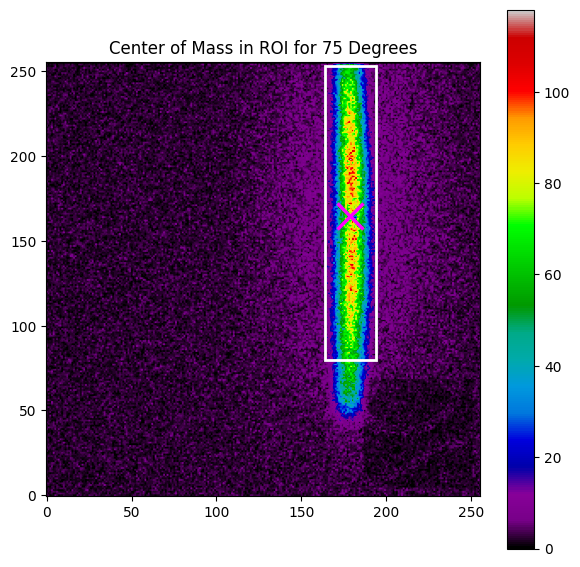

In [16]:
index = 28
print(album[index].calc_com())
album[index].set_image_size(7)
album[index].show_com()

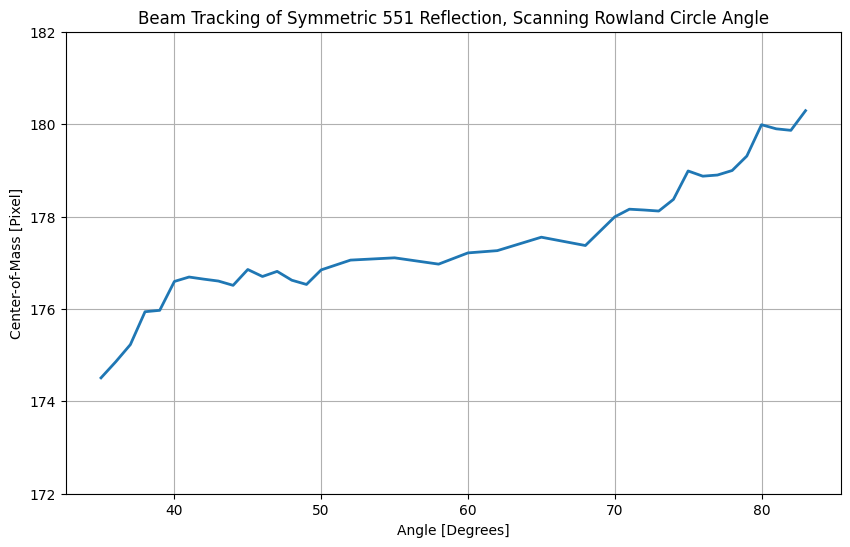

In [18]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(com_angles, com_list, linewidth=2.0)
ax.set_xlabel('Angle [Degrees]')
ax.set_ylabel('Center-of-Mass [Pixel]')
ax.set_title('Beam Tracking of Symmetric 551 Reflection, Scanning Rowland Circle Angle') 
ax.set_ylim(172, 182)
ax.grid(True)

/var/folders/08/31xwkz5d45j2zjsj4dl9n0q40000gn/T/ipykernel_36888/1345496267.py:8: MatplotlibDeprecationWarning: The modification of the Axes.lines property was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use Artist.remove() instead.
  del ax.lines[1]


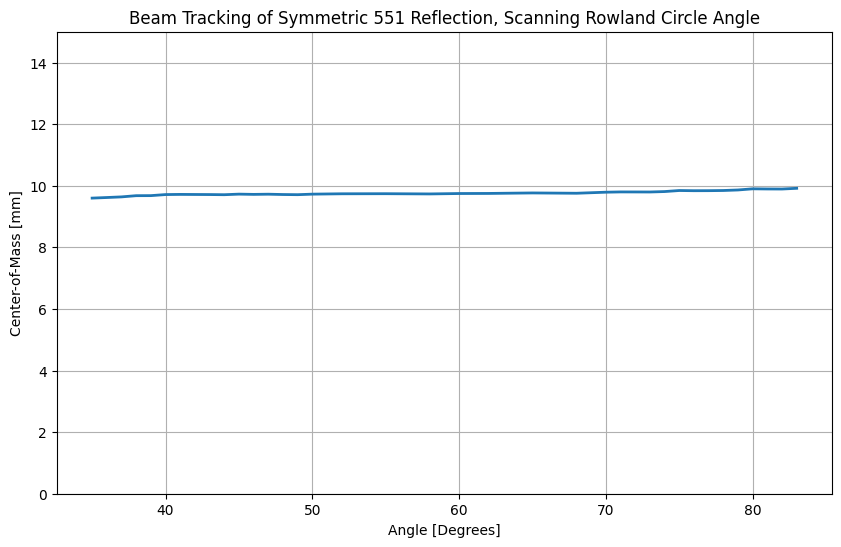

In [19]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(com_angles, com_list_mm, linewidth=2.0)
ax.set_xlabel('Angle [Degrees]')
ax.set_ylabel('Center-of-Mass [mm]')
ax.set_title('Beam Tracking of Symmetric 551 Reflection, Scanning Rowland Circle Angle') 
ax.set_ylim(0, 15)
ax.grid(True)
del ax.lines[1]

35 Degrees: (174.50792915623356, 126.81420638481616)

83 Degrees: (180.29124552353207, 168.6325893226301)

x-coord. delta: 5.783316367298511


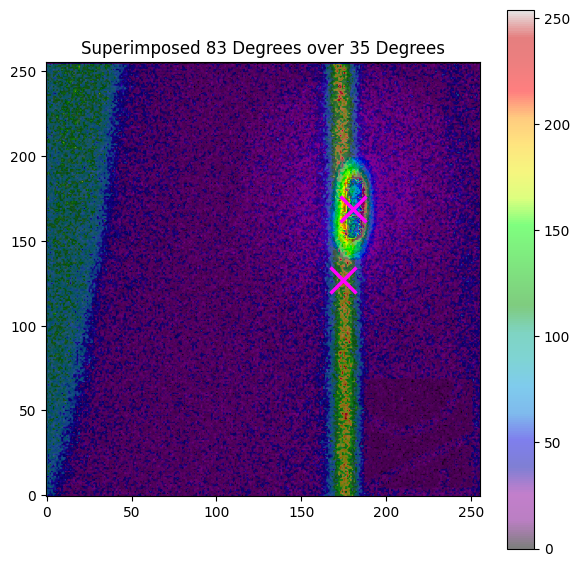

In [17]:
overlay(album[0], album[36], show_com = True, size = 7)